Based on https://colab.research.google.com/github/google/neural-tangents/blob/main/notebooks/neural_tangents_cookbook.ipynb

https://neural-tangents.readthedocs.io/en/latest/


In [1]:
%load_ext autoreload
%autoreload 2

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

####

from jax import config; config.update('jax_enable_x64', True)

import numpy as onp
import jax.numpy as np

from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

####

from scipy.special import factorial, factorial2
import math
import copy

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None):
    # plt.grid(False)
    ax = plt.gca()
    if x is not None:
        plt.xlabel(x, fontsize=20)
    if y is not None:
        plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
        shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

/var/folders/jl/5t2tdyk93j71vbj1n9wmflnh0077qh/T/ipykernel_21714/1391702289.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [3]:
# Probabilist's non-normalized Hermite polynomials
# I use standard numpy here because I operate with arrays of different lengths which I typically sum
# No implementation of Gegenbauer's polynomials --
# seems not to be easily computable for big d which is the case we are interested in
class HermitePolynomials:
    def __init__(self):
        self.hermite_polynomials = [
            onp.array([1.]),
            onp.array([0., 1.])
        ]
        
    def __getitem__(self, item):
        self._update_poly(item)
        return self.hermite_polynomials[item]
            
    def _update_poly(self, degree):
        if degree < len(self.hermite_polynomials):
            return
        self._update_poly(degree - 1)
        
        new_poly = onp.zeros(degree + 1)
        new_poly[1:] += onp.array(self.hermite_polynomials[degree - 1])
        new_poly[:-2] += - (degree - 1) * onp.array(self.hermite_polynomials[degree - 2])
        self.hermite_polynomials.append(new_poly)
        
        
HERMITE = HermitePolynomials()


def check_poly_validity(coef):
    assert len(coef) > 0 and (len(coef) == 1 or coef[-1] != 0), "Wrong polynomial format"


def hermite2classic(hermite_coef):
    n_coef = len(hermite_coef)
    classic_coef = onp.zeros(n_coef)
    for idx_poly in range(n_coef):
        classic_coef[:idx_poly + 1] += hermite_coef[idx_poly] * HERMITE[idx_poly]
    return classic_coef


def classic2hermite(classic_coef):
    n_coef = len(classic_coef)
    classic_coef = onp.array(classic_coef)
    hermite_coef = onp.zeros(n_coef)
    
    for idx_poly in range(n_coef - 1, -1, -1):
        hermite_coef[idx_poly] = classic_coef[idx_poly]
        classic_coef[:idx_poly + 1] -= hermite_coef[idx_poly] * HERMITE[idx_poly]
    
    return hermite_coef


def classic_poly_norm_expectation(classic_coef):
    expectation = classic_coef[0]
    for idx in range(2, len(classic_coef), 2):
        expectation += classic_coef[idx] * factorial2(idx - 1)
    return expectation


    

HU_LU_EXAMPLE_G_COEF = np.array([0, 1, 1, 1./2, 1./20])

In [13]:
def prod_list(start, end):
    if start == end:
        return np.array([])
    pl = [start if start > 0 else 1]
    for i in range(start + 1, end):
        pl.append(pl[-1] * i)
    return np.array(pl)


class TargetFunction():
    def __init__(self):
        return
    
    def __call__(self, points):
        raise NotImplementedError()
        
    def SNR(self, K, sigma_z=0):
        raise NotImplementedError()
    
    def expectation(self):
        raise NotImplementedError()
    
    def expectation_sqr(self):
        raise NotImplementedError()
        
    def get_hermite_coef(self, K): # TODO what args
        raise NotImplementedError()

    
class PolynomialFunction(TargetFunction):
    def __init__(self, coef, poly_type='classic'):
        super(PolynomialFunction, self).__init__()
        check_poly_validity(coef)
        coef = onp.array(coef, dtype='float')
        self.deg = len(coef) - 1  # degree of polynomial
        if poly_type == 'classic':
            self.classic_coef = np.array(coef)
            self.hermite_coef = np.array(classic2hermite(coef))
        elif poly_type == 'hermite':
            self.hermite_coef = np.array(coef)
            self.classic_coef = np.array(hermite2classic(coef))
        else:
            raise ValueError('Unknown polynomial type')
    
    def __call__(self, points):
        return np.polyval(self.classic_coef[::-1], points)
        
    def SNR(self, K, sigma_z=0):  
        if K > self.deg:
            if sigma_z == 0.:
                return np.nan
            return 0
        
        snr_val = self.hermite_coef[K] ** 2 / \
        ((self.hermite_coef[K + 1:] ** 2 * prod_list(K + 1, self.deg + 1)).sum() + sigma_z ** 2 / factorial(K))
        return snr_val
    
    def expectation(self):
        return self.hermite_coef[0]
    
    def expectation_sqr(self):
        return (self.hermite_coef ** 2 * prod_list(0, self.deg + 1)).sum()    

    
    

In [14]:
class ActivationFunction:
    def __init__(self):
        pass

    def __call__(self, points):
        raise NotImplementedError()
    
    def get_layer(self):
        raise NotImplementedError
        
    def rho(self, K, lreg=0., sigma_W2=0.):
        raise NotImplementedError()
    
    

class PolynomialActivation(ActivationFunction):
    def __init__(self, coef, poly_type='classic'):
        super(PolynomialActivation, self).__init__()
        check_poly_validity(coef)
        coef = onp.array(coef, dtype='float')
        self.deg = len(coef) - 1  # degree of polynomial
        if poly_type == 'classic':
            self.classic_coef = np.array(coef)
            self.hermite_coef = np.array(classic2hermite(coef))
        elif poly_type == 'hermite':
            self.hermite_coef = np.array(coef)
            self.classic_coef = np.array(hermite2classic(coef))
        else:
            raise ValueError('Unknown polynomial type')
        self.classic_deriv_coef = self.classic_coef[1:] * np.arange(1, self.deg + 1)
        self._init_kernel_coef()
    
    def __call__(self, points):
        return np.polyval(self.classic_coef[::-1], points)
    
    def apply_deriv(self, points):
        return np.polyval(self.classic_deriv_coef[::-1], points)
    
    def get_layer(self):
        return stax.Polynomial(self.classic_coef)
    
    def _init_kernel_coef(self):
        self.kernel_coef = self.hermite_coef ** 2 * factorial(onp.arange(0, self.deg + 1))
        self.kernel_deriv_coef = onp.zeros(self.deg + 1)
        self.kernel_deriv_coef[1:] = onp.array(self.kernel_coef[1:]) * np.arange(1, self.deg + 1)
    
    def rho(self, K, lreg=0., sigma_W2=0.):
        if K > self.deg:
            if lreg == 0.:
                return np.nan
            return 0
        
        val = (1 + K * sigma_W2 ** 2) * self.hermite_coef[K] ** 2 / \
            (((1 + np.arange(K + 1, self.deg + 1) * sigma_W2 ** 2) * self.hermite_coef[K + 1:] ** 2 * prod_list(K + 1, self.deg + 1)).sum() 
             + lreg / factorial(K))
        return val
    
    def ntk_coef(self, sigma_W2=0.):
        return self.kernel_coef + sigma_W2 ** 2 * self.kernel_deriv_coef
    
    def kernel(self, X, Y=None, sigma_W2=0.):
        # mostly for sanity check purpose
        if Y is None:
            Y = X
        d = X.shape[1]
        scalar_prod = (X @ Y.T / d)
        result = np.polyval(self.ntk_coef(sigma_W2)[::-1], scalar_prod)
        return result


In [6]:
def get_n_train(dimension, K, delta_K):
    return round(delta_K * dimension ** K)


def read_fraction_list(arr):
    return list(map(lambda x: eval(x) if isinstance(x, str) else x, arr))


def get_target_function(kind='poly', **kwargs):
    if kind == 'poly':
        kwargs['coef'] = read_fraction_list(kwargs['coef'])
        return PolynomialFunction(**kwargs)
    else:
        raise NotImplementedError()


def get_activation_function(kind='poly', **kwargs):
    if kind == 'poly':
        kwargs['coef'] = read_fraction_list(kwargs['coef'])
        return PolynomialActivation(**kwargs)
    else:
        raise NotImplementedError()


def generate_uniform_sphere_sample(key, n, d):
    X = random.normal(key, shape=(n, d))
    X = X / np.linalg.norm(X, axis=-1)[:, np.newaxis] * np.sqrt(d)
    return X


# todo: vary labels train-test
def plot_fn(xi_weights, g_fn, X, y, n_plot_points=1000, label_points='train'):
    dimension = xi_weights.shape[-1] 
    scalar_prod = X @ xi_weights.T / np.sqrt(dimension)
    # print(scalar_prod)
    # assert False
    
    x_plot_points = np.linspace(-np.sqrt(dimension), np.sqrt(dimension), n_plot_points)
    y_plot_points = g_fn(x_plot_points)
    
    plt.plot(x_plot_points, y_plot_points, label='true')
    # plt.plot(test_xs, f(test_xs), '-', linewidth=3)
    plt.plot(scalar_prod, y, 'ro', markersize=2, label=label_points)

#     if test != None:
#         test_xs, test_ys = test
#         plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

#     for f in fs:
#         plt.plot(test_xs, f(test_xs), '-', linewidth=3)
    ymin, ymax = plt.gca().get_ylim()
    
    plt.xlim([-np.sqrt(dimension) * 1.05, np.sqrt(dimension) * 1.05])
    plt.vlines([-np.sqrt(dimension), np.sqrt(dimension)], ymin, ymax, linestyles='dashed', color='grey', alpha=0.5)
    # plt.ylim([-1.5, 1.5])
    plt.legend()
    format_plot('$\\langle x, \\xi \\rangle / \\sqrt{{d}}$', '$y$')
    
# plot_fn(xi_weights, g_fn, X_train, y_train)

In [7]:
# TODO I've taken this expectation from HL2022 (34),
# but is it correct?
def dsphere_1c_expectation(d, m):
    # for [- sqrt(d), sqrt(d)]
    if m % 2 == 1:
        return 0
    k = m // 2
    res = factorial2(2 * k - 1) / onp.prod(1 + 2 * onp.arange(0, k) / d)
    return res


def dsphere_2c_expectation(d, k, m):
    if k % 2 == 1 or m % 2 == 1:
        return 0
    k = k // 2
    m = m // 2
    res = factorial2(2 * k - 1) * factorial2(2 * m - 1) / onp.prod(1 + 2 * onp.arange(0, k + m) / d)
    return res


# dsphere_1c_expectation(1000, 10)
# dsphere_2c_expectation(1000, 6, 8)

https://neural-tangents.readthedocs.io/en/latest/_autosummary/neural_tangents.stax.Dense.html#neural_tangents.stax.Dense

In [47]:
def classic_poly_square(classic_coef):
    # TODO: optimize?
    classic_coef = onp.array(classic_coef)
    n_coef_old = classic_coef.shape[-1]
    n_coef_new = (n_coef_old - 1) * 2 + 1
    square_coef = onp.zeros(list(classic_coef.shape[:-1])+[n_coef_new])
    for i in range(n_coef_old):
        square_coef[...,2 * i] += classic_coef[...,i] ** 2
        for j in range(i + 1, n_coef_old):
            square_coef[...,i + j] += 2 * classic_coef[...,i] * classic_coef[...,j]
    return square_coef


def classic_poly_dsphere_1c_expectation(classic_coef, d):
    classic_coef = onp.array(classic_coef)
    expectation = 0
    for i in range(0, classic_coef.shape[-1], 2):
        expectation += classic_coef[..., i] * dsphere_1c_expectation(d, i)
    return expectation


def classic_poly_dsphere_2c_expectation(classic_coef, d):
    classic_coef = onp.array(classic_coef)
    expectation = 0
    for k in range(0, classic_coef.shape[-2], 2):
        for m in range(0, classic_coef.shape[-1], 2):
            expectation += classic_coef[..., k, m] * dsphere_2c_expectation(d, k, m)
    return expectation


def classic_poly_mul(classic_coef_a, classic_coef_b):
    # first can be array, second must be 1d poly
    if classic_coef_a.ndim < classic_coef_b.ndim:
        return classic_poly_mul(classic_coef_b, classic_coef_a)
    n_coef_a = classic_coef_a.shape[-1]
    n_coef_b = classic_coef_b.shape[-1]
    n_coef = n_coef_a + n_coef_b - 1
    zero_pad = [(0, 0)] * (classic_coef_a.ndim - 1)
    res_coef = np.stack([np.pad(classic_coef_a * classic_coef_b[..., i:i+1],
                                pad_width=zero_pad + [(i, n_coef_b - i - 1)], mode='constant', constant_values=0)
                    for i in range(n_coef_b)]).sum(axis=0) 
    return res_coef


def classic_poly_1d_rescale(classic_coef, scale):
    # in case we have p(x) and want p'(x) = p(scale * x)
    n_coef = len(classic_coef)
    return (scale[..., np.newaxis] ** np.arange(n_coef)) * classic_coef


def classic_poly_2d_normalize(classic_coef, dimension):
    # in case we have p(x) and want p'(x * sqrt(d)) = p(x)all
    n_coef_a = classic_coef.shape[-2]
    n_coef_b = classic_coef.shape[-1]
    return classic_coef * (1 / np.sqrt(dimension) ** np.arange(n_coef_a))[:, np.newaxis] * \
       (1 / np.sqrt(dimension) ** np.arange(n_coef_b))


def polynomial_1d_expansion(classic_coef, alpha, beta):
    # i.e. we have polynomial p(x) and want to expand p(alpha_i x + beta_i y) (can be indexed by ij, ijk, etc.)
    # axis up to -3: index of sample based on alpha/beta shapes (p is 1d array); -2: degree of x; -1: degree of y
    n_coef = len(classic_coef)
    
    new_coefs = onp.zeros((n_coef, n_coef))
    for i in range(n_coef):
        for j in range(i + 1):
            new_coefs[j, i - j] = classic_coef[i] * math.comb(i,j)
    
    polynomial_2d = np.triu(((alpha[..., np.newaxis] ** np.arange(n_coef))[..., np.newaxis] *
        (beta[..., np.newaxis] ** np.arange(n_coef))[..., np.newaxis,:])[...,::-1])[...,::-1] * new_coefs 
    

    return polynomial_2d


def compute_krr_mse_poly_infinite(X_train, g_fn, xi_weights, activation,
                                  learned_weights, sigma_W2):
    dimension = X_train.shape[1]
    total_error = classic_poly_dsphere_1c_expectation(
        classic_poly_square(g_fn.classic_coef), dimension)  # first component, g^2
    
    weight_xi = np.clip(X_train @ xi_weights.T / dimension, -1, 1)[:,0] # second component, g * K
    weight_xi_orth = np.sqrt(1 - weight_xi ** 2)
    poly_kernel_gK = polynomial_1d_expansion(
        activation.ntk_coef(sigma_W2), weight_xi, weight_xi_orth
    ).transpose((1, 2, 0)).dot(learned_weights[:,0])
    poly_kernel_gK = classic_poly_2d_normalize(poly_kernel_gK, dimension)
    total_error -= 2 * classic_poly_dsphere_2c_expectation(
        classic_poly_mul(poly_kernel_gK.T, g_fn.classic_coef).T, dimension)
    
    weight_xi = np.clip(X_train @ X_train.T / dimension, -1, 1)
    weight_xi_orth = np.sqrt(1 - weight_xi ** 2)
    poly_kernel_KK = polynomial_1d_expansion(
        activation.ntk_coef(sigma_W2), weight_xi, weight_xi_orth
    ).transpose((2, 3, 0, 1)).dot(learned_weights[:,0]).dot(learned_weights[:,0])
    
    total_error += classic_poly_dsphere_2c_expectation(
        classic_poly_2d_normalize(classic_poly_mul(poly_kernel_KK.T, activation.ntk_coef(sigma_W2)).T, dimension),
        dimension)
    return total_error


def compute_krr_mse_poly_finite(X_train, params, g_fn, xi_weights, activation, learned_weights, sigma_W2):
    dimension = X_train.shape[1]
    
    th_error_g_g = classic_poly_dsphere_1c_expectation(
        classic_poly_square(g_fn.classic_coef), dimension)

    W1, W2 = params[0][0], params[2][0][:, 0]
    N_width = W1.shape[1]
    
    weight_W1 = np.linalg.norm(W1, axis=0) / np.sqrt(dimension)
    W1_normalized = W1 / weight_W1
    weight_W1_X = (X_train @ W1_normalized / dimension).T
    
    F_train = activation(X_train @ W1 / np.sqrt(dimension))
    F_deriv_train = activation.apply_deriv(X_train @ W1 / np.sqrt(dimension))
    F_train_weighted = F_train.T @ learned_weights[:, 0]
    
    weight_W1_xi = np.clip(W1_normalized.T @ xi_weights.T / dimension, -1, 1)[:,0] 
    weight_W1_xi_orth = np.sqrt(1 - weight_W1_xi ** 2)
    
    poly_g_K2 = polynomial_1d_expansion(
        activation.classic_coef, weight_W1_xi * weight_W1, weight_W1_xi_orth * weight_W1
    )
    poly_g_K2 = (F_train_weighted[:, np.newaxis, np.newaxis] * poly_g_K2).mean(axis=0)
    th_error_g_K2 = classic_poly_dsphere_2c_expectation(
        classic_poly_mul(poly_g_K2 .T, g_fn.classic_coef).T, dimension)
    
    weight_X_xi = np.clip(X_train @ xi_weights.T / dimension, -1, 1)[:,0]
    weight_X_xi_orth = np.sqrt(1 - weight_X_xi ** 2) 
    weight_coord_x1 = F_deriv_train.T @ (learned_weights[:,0] * weight_X_xi)
    weight_coord_x2 = ((weight_W1_X - weight_W1_xi[:, np.newaxis] * weight_X_xi[np.newaxis, :]) *  
                      F_deriv_train.T @ learned_weights[:,0]) / weight_W1_xi_orth
    poly_g_K1 = (W2[:, np.newaxis, np.newaxis] ** 2) * polynomial_1d_expansion(
        activation.classic_deriv_coef, weight_W1_xi * weight_W1, weight_W1_xi_orth * weight_W1
    )
    poly_g_K1_x1 = (poly_g_K1 * weight_coord_x1[:, np.newaxis, np.newaxis]).mean(axis=0) 
    poly_g_K1_x2 = (poly_g_K1 * weight_coord_x2[:, np.newaxis, np.newaxis]).mean(axis=0) 
    poly_g_K1 = onp.zeros(onp.array(poly_g_K1_x1.shape)+1)
    poly_g_K1[1:, :-1] += poly_g_K1_x1
    poly_g_K1[:-1, 1:] += poly_g_K1_x2
    
    th_error_g_K1 = classic_poly_dsphere_2c_expectation(
        classic_poly_mul(poly_g_K1.T, g_fn.classic_coef).T, dimension) / np.sqrt(dimension)
    
    
    weight_W1_W1 = np.clip(W1_normalized.T @ W1_normalized / dimension, -1, 1)
    weight_W1_W1_orth = np.sqrt(1 - weight_W1_W1 ** 2)
    sigma_W1_expansion = classic_poly_1d_rescale(activation.classic_coef, weight_W1)
    
    poly_K2_K2 = polynomial_1d_expansion(activation.classic_coef, weight_W1_W1 * weight_W1[np.newaxis, :],
                                  weight_W1_W1_orth * weight_W1[np.newaxis, :])
    poly_K2_K2 = poly_K2_K2.transpose((0, 2, 3, 1)) @ F_train_weighted / N_width
    poly_K2_K2 = classic_poly_mul(poly_K2_K2.transpose((0, 2, 1)),
                                  sigma_W1_expansion[:, np.newaxis, :])
    poly_K2_K2 = poly_K2_K2.transpose((2, 1, 0)) @ F_train_weighted / N_width
    th_error_K2_K2 = classic_poly_dsphere_2c_expectation(poly_K2_K2, dimension)
    
    F_deriv_weighted_2coord = weight_W1_X * learned_weights[:, 0] @ F_deriv_train / np.sqrt(dimension)
    F_deriv_weighted_1coord = (weight_W1_X * F_deriv_train.T) @ learned_weights[:, 0] / np.sqrt(dimension) 
    sigma_deriv_W1_W1_expansion = polynomial_1d_expansion(activation.classic_deriv_coef, weight_W1_W1 * weight_W1[np.newaxis, :],
                                  weight_W1_W1_orth * weight_W1[np.newaxis, :])
    
    def reduce_K2_K1(poly):
        poly = (sigma_deriv_W1_W1_expansion *
                poly[..., np.newaxis, np.newaxis]).transpose((0, 2, 3, 1)) @ W2 ** 2 / N_width 
        poly = classic_poly_mul(poly.transpose((0, 2, 1)), sigma_W1_expansion[:, np.newaxis, :])
        poly = poly.transpose((2, 1, 0)) @ F_train_weighted / N_width 
        return poly
        
    poly_K2_K1_x1 = F_deriv_weighted_2coord
    poly_K2_K1_x2 = (F_deriv_weighted_1coord[np.newaxis, :] - weight_W1_W1 * F_deriv_weighted_2coord) # / weight_W1_W1_orth
    poly_K2_K1_x2 = np.where(np.abs(weight_W1_W1) == 1, 0, poly_K2_K1_x2 / weight_W1_W1_orth)
    poly_K2_K1_x1 = reduce_K2_K1(poly_K2_K1_x1)
    poly_K2_K1_x2 = reduce_K2_K1(poly_K2_K1_x2)
    poly_K2_K1 = onp.zeros(onp.array(poly_K2_K1_x1.shape)+1)
    poly_K2_K1[1:, :-1] += poly_K2_K1_x1
    poly_K2_K1[:-1, 1:] += poly_K2_K1_x2
    th_error_K2_K1 = classic_poly_dsphere_2c_expectation(poly_K2_K1, dimension)
    
    sigma_deriv_W1_expansion = classic_poly_1d_rescale(activation.classic_deriv_coef, weight_W1)
    
    poly_K1_K1_x1_x1 = F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_2coord
    poly_K1_K1_x1_x2 = (F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_1coord[np.newaxis, :] +  
                       F_deriv_weighted_2coord * F_deriv_weighted_2coord.T -  
                       2 * weight_W1_W1 * F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_2coord) / weight_W1_W1_orth
    poly_K1_K1_x2_x2 = (F_deriv_weighted_2coord.T * F_deriv_weighted_1coord[np.newaxis, :] 
                        - (F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_1coord[np.newaxis, :] +
                           F_deriv_weighted_2coord.T * F_deriv_weighted_2coord) * weight_W1_W1 +
                       F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_2coord * weight_W1_W1 ** 2) / \
                        (1 - weight_W1_W1**2)
    poly_K1_K1_x3_x3 = ((F_deriv_train.T * learned_weights[:, 0]) @ X_train / dimension @ X_train.T @ \
                       (F_deriv_train.T * learned_weights[:, 0]).T / dimension)
    poly_K1_K1_x3_x3_diag = poly_K1_K1_x3_x3 -  F_deriv_weighted_1coord[np.newaxis, :] ** 2
    poly_K1_K1_x3_x3_out_diag = poly_K1_K1_x3_x3 + (
         weight_W1_W1 * (F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_1coord[np.newaxis, :] +  
         F_deriv_weighted_2coord * F_deriv_weighted_2coord.T) - 
         (F_deriv_weighted_1coord[:, np.newaxis] * F_deriv_weighted_2coord +
          F_deriv_weighted_2coord.T * F_deriv_weighted_1coord[np.newaxis, :])
    ) / (1 - weight_W1_W1**2)
    
    poly_K1_K1_x1_x2 = np.where(np.abs(weight_W1_W1) == 1, 0, poly_K1_K1_x1_x2) 
    poly_K1_K1_x2_x2 = np.where(np.abs(weight_W1_W1) == 1, 0, poly_K1_K1_x2_x2) 
    poly_K1_K1_x3_x3 = np.where(np.abs(weight_W1_W1) == 1, poly_K1_K1_x3_x3_diag,
                                 poly_K1_K1_x3_x3_out_diag)
    
    def reduce_K1_K1(poly):
        poly = (sigma_deriv_W1_W1_expansion *
                poly[..., np.newaxis, np.newaxis]).transpose((0, 2, 3, 1)) @ W2 ** 2 / N_width 
        poly = classic_poly_mul(poly.transpose((0, 2, 1)), sigma_deriv_W1_expansion[:, np.newaxis, :])
        poly = poly.transpose((2, 1, 0)) @ W2 ** 2 / N_width  
        return poly
    
    poly_K1_K1_x1_x1 = reduce_K1_K1(poly_K1_K1_x1_x1) 
    poly_K1_K1_x1_x2 = reduce_K1_K1(poly_K1_K1_x1_x2) 
    poly_K1_K1_x2_x2 = reduce_K1_K1(poly_K1_K1_x2_x2) 
    poly_K1_K1_x3_x3 = reduce_K1_K1(poly_K1_K1_x3_x3)
    
    poly_K1_K1 = onp.zeros(onp.array(poly_K1_K1_x1_x1.shape) + 2)
    poly_K1_K1[2:, :-2] += poly_K1_K1_x1_x1
    poly_K1_K1[1:-1, 1:-1] += poly_K1_K1_x1_x2
    poly_K1_K1[:-2, 2:] += poly_K1_K1_x2_x2
    poly_K1_K1[:-2, :-2] +=  (dimension / (dimension + np.arange(poly_K1_K1_x3_x3.shape[0])[:, np.newaxis]
                              + np.arange(poly_K1_K1_x3_x3.shape[1])[np.newaxis, :])) * poly_K1_K1_x3_x3
    th_error_K1_K1 = classic_poly_dsphere_2c_expectation(poly_K1_K1, dimension)
    total_error = th_error_g_g - 2 * (th_error_g_K1 + th_error_g_K2) + \
                 (th_error_K1_K1 + 2 * th_error_K2_K1 + th_error_K2_K2)
    
    # return {'test_error': total_error.item(), 'g_g': th_error_g_g.item(),
    #         'g_K1': th_error_g_K1.item(), 'g_K2': th_error_g_K2.item(),
    #         'K1_K1': th_error_K1_K1.item(), 'K1_K2': th_error_K2_K1.item(), 'K2_K2': th_error_K2_K2.item()}
    return total_error.item()
    
    
def run_experiment(cfg):
    key = random.PRNGKey(cfg.seed)
    
    K = cfg.math_params.K
    n_train = cfg.math_params.n
    dimension = cfg.math_params.d
    delta_K = n_train / dimension ** K 
    
    sigma_noise = cfg.math_params.sigma_z
    g_fn = get_target_function(**cfg.target_function)
    
    key, X_train_key, xi_key, z_train_key = random.split(key, 4)
    # todo: introduce storing datasets in case X_train is too large
    # todo: check what specifications of NTK people typically use
    X_train = generate_uniform_sphere_sample(X_train_key, n_train, dimension)
    xi_weights = generate_uniform_sphere_sample(xi_key, 1, dimension)
    z_train = sigma_noise * random.normal(z_train_key, (n_train, 1))
    y_train = g_fn(X_train @ xi_weights.T / np.sqrt(dimension)) + z_train

    # todo: define N in smart enough way
    
    sigma_W2 = cfg.math_params.sigma_W2
    N_width = cfg.math_params.N_width
    
    lreg = cfg.math_params.lmbd
    activation = get_activation_function(**cfg.activation)
    init_fn, apply_fn, kernel_ntk_inf_fn = stax.serial(
        stax.Dense(N_width, W_std=np.sqrt(dimension), b_std=None, parameterization='standard'),
        activation.get_layer(),
        stax.Dense(1, W_std=sigma_W2 * np.sqrt(N_width), b_std=None, parameterization='standard')
    )
    kernel_ntk_inf_fn = jit(kernel_ntk_inf_fn, static_argnames='get')
    K_ntk_inf_train = kernel_ntk_inf_fn(X_train / np.sqrt(dimension), X_train / np.sqrt(dimension), 'ntk') / N_width 
    
    predictor = nt.predict.gp_inference(K_ntk_inf_train, y_train, diag_reg=lreg, diag_reg_absolute_scale=True)
    # hack to obtain weights:
    learned_weights = predictor('ntk', np.eye(n_train))
    key, X_test_key = random.split(key, 2)
    n_test = cfg.math_params.n_test
    X_test = generate_uniform_sphere_sample(X_test_key, n_test, dimension)
    y_test = g_fn(X_test @ xi_weights.T / np.sqrt(dimension))
    K_ntk_inf_test_train = kernel_ntk_inf_fn(X_test / np.sqrt(dimension), X_train / np.sqrt(dimension), 'ntk').reshape((n_test, n_train)) / N_width
    y_pred = predictor('ntk', K_ntk_inf_test_train)
    # print(y_pred.mean())
    # print(activation.kernel(X_test, X_train, sigma_W2).mean() * learned_weights.sum())
    # print(classic_poly_dsphere_1c_expectation(activation.ntk_coef(sigma_W2), dimension) * learned_weights.sum())

    # plot_fn(xi_weights, g_fn, X_test, y_pred, label_points='test')
    
    
    test_error = ((y_pred - y_test) ** 2).mean()
    
    # THIS IS VERY POLYNOMIAL CENTRIC; later - remove/do a check/organize
    total_error = compute_krr_mse_poly_infinite(X_train, g_fn, xi_weights, activation,
                                  learned_weights, sigma_W2)
    
    # print(test_error)
    print(total_error)
    
    
    print('######')
    

    kwargs = dict(
      f=apply_fn,
      trace_axes=(),
      vmap_axes=0
    )

    empirical_ntk = jit(nt.empirical_ntk_fn(
      **kwargs, implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES))

    apply_fn = jit(apply_fn)
    
    key, net_key = random.split(key)
    _, params = init_fn(net_key, (-1, dimension))
    # print(params[0][0].std(), params[2][0].std())
    result_draw = apply_fn(params, X_train  / np.sqrt(dimension)) / np.sqrt(N_width)
    # print(np.abs(result_draw - activation(X_train @ params[0][0] / np.sqrt(dimension)) @ params[2][0] / np.sqrt(N_width)).max())
    
    K_ntk_emp_train = empirical_ntk(X_train / np.sqrt(dimension), X_train / np.sqrt(dimension), params)[:, :, 0, 0] / N_width
    predictor = nt.predict.gp_inference(K_ntk_emp_train, y_train, diag_reg=lreg, diag_reg_absolute_scale=True)
    # hack to obtain weights:
    learned_weights = predictor('ntk', np.eye(n_train))
    K_ntk_emp_test_train = empirical_ntk(X_test / np.sqrt(dimension), X_train / np.sqrt(dimension), params)[:,:,0,0]/ N_width
    y_pred = predictor('ntk', K_ntk_emp_test_train)
    
    
    # To comment out
    params_K2 = copy.deepcopy(params)
    params_K2[2] = (params_K2[2][0] * 0, None) 
    K_ntk_2_emp_test_train = empirical_ntk(X_test / np.sqrt(dimension), X_train / np.sqrt(dimension), params_K2)[:,:,0,0]/ N_width
    K_ntk_1_emp_test_train = K_ntk_emp_test_train - K_ntk_2_emp_test_train
    y_pred_K2 = predictor('ntk', K_ntk_2_emp_test_train)
    y_pred_K1 = predictor('ntk', K_ntk_1_emp_test_train)
    
    total_error = compute_krr_mse_poly_finite(X_train, params, g_fn, xi_weights, activation, learned_weights, sigma_W2)
    # print(((y_test - y_pred) ** 2).mean())
    print(total_error)
    
    
    # todo: separate module
    snr = g_fn.SNR(K, sigma_z=sigma_noise)
    rho = activation.rho(K, lreg=lreg, sigma_W2=sigma_W2)
    r = math.sqrt((1 + rho - rho * delta_K) ** 2 + 4 * rho * delta_K)
    Vh = (1 + rho + delta_K * rho) / (2 * r) - 0.5
    Bh = (1 - delta_K) / 2 + (1 + delta_K + rho * (1 - delta_K) ** 2) / (2 * r)
    Bh_K = g_fn.hermite_coef[K] ** 2 * factorial(K) * Bh
    Bh_gK = (g_fn.hermite_coef[K + 1:] ** 2 * factorial(K) * prod_list(K + 1, g_fn.deg + 1)).sum() * (Vh + 1)
    Vh = sigma_noise ** 2 * Vh
    print(Bh_K + Bh_gK + Vh)
    
#     print((y_test * y_pred_K2).mean(), th_error_g_K2 , 'diff:', (y_test * y_pred_K2).mean() - th_error_g_K2)
#     print((y_test * y_pred_K1).mean(), th_error_g_K1, 'diff:', (y_test * y_pred_K1).mean() - th_error_g_K1)
#     print((y_pred_K2 * y_pred_K2).mean(), th_error_K2_K2, 'diff:', (y_pred_K2 * y_pred_K2).mean() - th_error_K2_K2)
#     print((y_pred_K1 * y_pred_K2).mean(), th_error_K2_K1, 'diff:', (y_pred_K1 * y_pred_K2).mean() - th_error_K2_K1)
#     print((y_pred_K1 * y_pred_K1).mean(), th_error_K1_K1, 'diff:', (y_pred_K1 * y_pred_K1).mean() - th_error_K1_K1)
#     print(((y_test - y_pred) ** 2).mean(), total_error, 'diff:', ((y_test - y_pred) ** 2).mean() - total_error)
    
    
    
#     poly_K2_K1_x1 
#     print(np.concatenate([np.zeros(tuple([poly_K2_K1_x1.shape[0], 1, poly_K2_K1_x1.shape[2]])), poly_K2_K1_x1], axis=1))
    
    
    
    # print(weight_X_train_xi_orth)
    #     print(empirical_ntk(X_train, X_train, params)[:, :, 0, 0] / N_width)


    #     print('sigma est:', np.sqrt((params[0][0] ** 2 * dimension).mean()), np.sqrt((params[-1][0] ** 2 * dimension).mean()))

    #     print(activation(X_train @ params[0][0]) @ params[2][0] / np.sqrt(dimension))
    #     


    #     features = activation(X_train @ params[0][0])
    #     features_deriv = activation.apply_deriv(X_train @ params[0][0]) * params[2][0][:,0]

    #     print(empirical_ntk(X_train, X_train, params)[:, :, 0, 0] / N_width -
    #           (features @ features.T / N_width + (X_train @ X_train.T) * (features_deriv @ features_deriv.T) / N_width))
    
    # print(activation.rho(K, lreg, sigma_W2))
    # TODO: IMPLEMENT THEORETICAL VALUE OF TEST ERROR!!!!



with initialize(version_base=None, config_path="../conf"):
    # cfg=compose(config_name="config.yaml", overrides=["computation=empirical"]) 
    cfg=compose(config_name="config.yaml", overrides=["computation=empirical", "activation.coef=[0,1,1,1]",
                                                      "math_params.n=5000","math_params.d=500", "math_params.K=1",
                                                       "math_params.sigma_W2=1", "math_params.N_width=100",
                                                     "math_params.n_test=100", "seed=5936"]) #  ,
run_experiment(cfg)

5.330974403221644
######
7.211689644482323
5.445974981807683


https://en.wikipedia.org/wiki/Hermite_polynomials 

Important note about initialization:
-  `parameterization = 'NTK'` -> weights have variance 1 and divided by $\sqrt{d}$ for first layer, $\sqrt{N}$ for second one, during application 
-  `parameterization = 'standard'` -> weights have custom variance and already considered to be divided by $\sqrt{d}$ and $\sqrt{N}$ correspondingly, application of layers is just multiplication

Hypergeometric function (used for ReLU rho parameter computation): https://mpmath.org/doc/current/functions/hypergeometric.html

$W_{ij} \sim \mathcal{N}(0,
        W_{std}^2/N)$
$z_i = \frac{1}{s} \sum_j W_{ij} x_j + b_i$


Exact computation of kernel: https://arxiv.org/pdf/1904.11955.pdf (ReLU is on the last page)

Empirical: neural_tangents.empirical

In [7]:
test = True
if test:
    # sanity check
    key, net_key = random.split(key)
    _, params = init_fn(net_key, (-1, dimension))
    
    # test that variance is correct
    print('true sigmas:', 1, sigma_W2)
    if parameterization_first == 'standard':
        print('sigma est:', np.sqrt((params[0][0] ** 2 * dimension).mean()), np.sqrt((params[-1][0] ** 2 * N_width).mean()))
    else:
        print('sigma est:', np.sqrt((params[0][0] ** 2).mean()), np.sqrt((params[-1][0] ** 2 * N_width).mean()))

    result_draw = apply_fn(params, X_train)

    # test that application of layers works as expected
    if parameterization_first == 'standard':
        print(np.abs(np.maximum(X_train @ params[0][0], 0) @ params[2][0] - result_draw).max())
    else:
        print(np.abs(np.maximum(X_train @ params[0][0] / np.sqrt(dimension), 0) @ params[2][0] - result_draw).max())


    # test that exact kernel computation matches
    k_eval = kernel_fn(X_train, X_train, 'ntk')
    x_prod = np.minimum(np.maximum(X_train @ X_train.T / dimension, -1), 1)
    K1_manual = sigma_W2 ** 2 * x_prod * (np.pi - np.arccos(x_prod)) / (2 * np.pi)
    K2_manual = (x_prod * (np.pi - np.arccos(x_prod)) + np.sqrt(1 - x_prod ** 2)) / (2 * np.pi)
    
    if parameterization_first == 'standard':
        print(np.abs(k_eval - K1_manual * dimension - K2_manual * N_width).max())
    else:
        print(np.abs(k_eval - K1_manual - K2_manual * N_width).max())
        
    
    # test that empirical kernel computation matches
    emp_ntk_eval = empirical_ntk(X_train, X_train, params).reshape((n_train, n_train))
    emp_K2_manual = np.maximum(X_train @ params[0][0] / np.sqrt(dimension), 0) @ \
                    np.maximum(X_train @ params[0][0] / np.sqrt(dimension), 0).T / N_width
    emp_K1_manual = ((X_train @ X_train.T) / dimension) * \
                     (((X_train @ params[0][0] / np.sqrt(dimension)) > 0).astype(np.float32) @
                      (np.diag(params[2][0][:, 0]) @ np.diag(params[2][0][:, 0])) @ 
                      ((X_train @ params[0][0] / np.sqrt(dimension)) > 0).astype(np.float32).T / N_width)

    if parameterization_first == 'standard':
        print(np.abs(emp_ntk_eval / (dimension * N_width) - (emp_K1_manual + emp_K2_manual)).max())
    else:
        print(np.abs(emp_ntk_eval / N_width - (emp_K1_manual + emp_K2_manual)).max())
        

NameError: name 'key' is not defined

Example of application of `nt.predict.gp_inference`:
https://github.com/google/neural-tangents/blob/main/examples/function_space.py

In [12]:
lreg = 1

emp_ntk_train_train_eval = empirical_ntk(X_train, X_train, params).reshape((n_train, n_train))
predictor = nt.predict.gp_inference(emp_ntk_train_train_eval, y_train, diag_reg=lreg, diag_reg_absolute_scale=True)
# hack to obtain weights:
learned_weights = predictor('ntk', np.eye(n_train))
learned_weights

Array([[-0.32269452],
       [-0.00228646],
       [ 0.02895458],
       ...,
       [ 0.16510781],
       [ 0.08387665],
       [ 0.47837588]], dtype=float64)

Reason why my manual solution did not work: https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/

How to make the solution more precise: https://github.com/google/neural-tangents/issues/128

In [13]:
key, X_test_key = random.split(key, 2)

n_test = 1000
X_test = generate_uniform_sphere_sample(X_test_key, n_test, dimension)
y_test = g_fn(X_test @ xi_weights.T / np.sqrt(dimension))

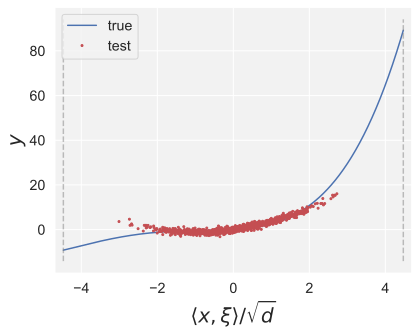

In [14]:
emp_ntk_test_train_eval = empirical_ntk(X_test, X_train, params).reshape((n_test, n_train))
# emp_ntk_test_test_eval = empirical_ntk(X_test, X_test, params).reshape((n_test, n_test))

y_pred = predictor('ntk', emp_ntk_test_train_eval)
plot_fn(xi_weights, g_fn, X_test, y_pred, label_points='test')

In [15]:
n_test_vals = 10 ** 6  # todo: choose in smart way

key, X_test_key = random.split(key, 2)
X_test = generate_uniform_sphere_sample(X_test_key, n_test, dimension)
y_test = g_fn(X_test @ xi_weights.T / np.sqrt(dimension))
emp_ntk_test_train_eval = empirical_ntk(X_test, X_train, params).reshape((n_test, n_train)) 

y_pred = predictor('ntk', emp_ntk_test_train_eval)
test_error = ((y_pred - y_test) ** 2).mean()
print(test_error)

1.6994096871653614


In [47]:
((y_pred - y_test) ** 2).mean()

Array(1.67289198, dtype=float64)

# DRAFT

## Understanding `nt.predict.gp_inference` prediction

In [ ]:
import numpy as onp
import jax.scipy as sp


def manual_kernel_ridge_regression_solution(kernel_train_train, y_train, lreg):
    n_train = kernel_train_train.shape[0]
    return sp.linalg.solve(kernel_train_train + lreg * np.eye(n_train), y_train)


learned_weights = manual_kernel_ridge_regression_solution(emp_ntk_eval, y_train, lreg)


def predict(kernel_test_train, weights):
    return kernel_test_train @ weights

y_pred_manual = predict(emp_ntk_test_train_eval, learned_weights)

plot_fn(xi_weights, g_fn, X_test, y_pred_manual)

In [ ]:
def _get_axes(x: np.ndarray):
  n = x.ndim
  return (
      tuple(range(0, n, 2)),
      tuple(range(1, n, 2)),
      tuple(range(0, n // 2)),
      tuple(range(n // 2, n))
  )


def _get_ndim(x):
    """Get number of dimensions given number of dimensions / shape / array."""
    if hasattr(x, 'ndim'):
        n = x.ndim
    elif hasattr(x, '__len__'):
        n = len(x)
    elif isinstance(x, int):
        n = x
    else:
        raise TypeError(x, type(x))
    return n


def canonicalize_axis(axis, x):
  """Converts axis into a sorted non-negative list.

  Args:
    axis: input axis.
    x: array / shape / number of dimensions.

  Returns:
    A sorted list of integer axes.
  """
  axis = [axis] if isinstance(axis, int) else list(axis)
  n = _get_ndim(x)
  return list(set(onp.arange(n)[axis]))


def _add_diagonal_regularizer(A: np.ndarray,
                              diag_reg: float,
                              diag_reg_absolute_scale: bool) -> np.ndarray:
    dimension = A.shape[0]
    if not diag_reg_absolute_scale:
        diag_reg *= np.trace(A) / dimension
    return A + diag_reg * np.eye(dimension)


def _get_cho_solve(A: np.ndarray,
                   diag_reg: float,
                   diag_reg_absolute_scale: bool,
                   lower: bool = False):
    x_non_channel_shape = A.shape[1::2]
    # A = utils.make_2d(A)
    A = _add_diagonal_regularizer(A, diag_reg, diag_reg_absolute_scale)
    print(np.abs(A - (emp_ntk_train_train_eval + lreg * np.eye(n_train))).max())
    C = sp.linalg.cho_factor(A, lower)
    # print(C)

    def cho_solve(b, b_axes):
        b_axes = canonicalize_axis(b_axes, b)
        last_b_axes = range(-len(b_axes), 0)
        x_shape = x_non_channel_shape + tuple(b.shape[a] for a in b_axes)

        b = np.moveaxis(b, b_axes, last_b_axes)
        b = b.reshape((A.shape[1], -1))
        # print(b - y_train)

        x = sp.linalg.cho_solve(C, b)
        x = x.reshape(x_shape)
        print(x)
        print(learned_weights)
        print(((A @ x - y_train) ** 2).sum())
        print(((A @ learned_weights - y_train) ** 2).sum())
        return x

    return cho_solve


_, odd, first, _ = _get_axes(emp_ntk_train_train_eval)
trace_axes = (-1,)
trace_axes = canonicalize_axis(trace_axes, y_train)
# so here the thing is in inversion of matrix

k_inv_y = _get_cho_solve(emp_ntk_train_train_eval, lreg, True)(y_train, trace_axes)

np.abs(
    np.tensordot(emp_ntk_test_train_eval, k_inv_y,
             (odd, first)) - predictor('ntk', emp_ntk_test_train_eval)).max()

##  Estimating how many samples we need to estimate test error correctly

In [ ]:
n_test_vals = [10, 100, 1000, 10000, 100000]
n_runs = 10

for n_test in n_test_vals:
    test_errors = []
    for _ in range(n_runs):
        key, X_test_key = random.split(key, 2)
        X_test = generate_uniform_sphere_sample(X_test_key, n_test, dimension)
        y_test = g_fn(X_test @ xi_weights.T / np.sqrt(dimension))
        emp_ntk_test_train_eval = empirical_ntk(X_test, X_train, params).reshape((n_test, n_train))
        # emp_ntk_test_test_eval = empirical_ntk(X_test, X_test, params).reshape((n_test, n_test))

        y_pred = predictor('ntk', emp_ntk_test_train_eval)
        test_errors.append(((y_pred - y_test) ** 2).mean())
    print(test_errors)

## Estimating how NTK in neural-tangents library works

In [ ]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(N_width, W_std=sigma_W1, b_std=None, parameterization='standard'),
    stax.Polynomial([0,1,1]),
    stax.Dense(1, W_std=sigma_W2, b_std=None, parameterization='standard')
)

K0 = X_train @ X_train.T / dimension
Theta0 = np.zeros(K0.shape)
K1 = K0 * sigma_W1 ** 2 
Theta1 = dimension * K0 + sigma_W1 ** 2 * Theta0
K2 = 2 * K1 ** 2 + K1 + sigma_W1 ** 4 
Theta2 = (4 * K1 + 1) * Theta1
K3 = K2 * sigma_W2 ** 2
Theta3 = N_width * K2 + sigma_W2 ** 2 * Theta2

print(K3 - kernel_fn(X_train, X_train, 'nngp'))
print(Theta3 - kernel_fn(X_train, X_train, 'ntk'))

## Checking I got polynomial coefficients right

In [ ]:
# TODO: possibly shorten?

weight_W1_X_orth = np.sqrt(1 - weight_W1_X ** 2)
xk_sans_ui = (X_train[np.newaxis, :, :] - W1_normalized.T[:, np.newaxis, :] * weight_W1_X[..., np.newaxis]) / weight_W1_X_orth[..., np.newaxis]
weight_xk_sans_ui_to_uj = (xk_sans_ui @ W1_normalized / dimension).transpose((0, 2, 1))
weight_xk_sans_ui_to_uj_orth = np.sqrt(1 - weight_xk_sans_ui_to_uj ** 2)
xk_sans_ui_uj = (xk_sans_ui[:, np.newaxis, :, :] - W1_normalized.T[np.newaxis, :, np.newaxis, :] * weight_xk_sans_ui_to_uj[..., np.newaxis]) / weight_xk_sans_ui_to_uj_orth[..., np.newaxis]
weight_xl_sans_ui_uj_to_xk = (xk_sans_ui_uj[:, :, :, np.newaxis, :] * xk_sans_ui_uj[:, :, np.newaxis, :, :]).sum(axis=-1) / dimension

coef_ui_ui = ((weight_W1_X[:, np.newaxis, :] * weight_W1_X[:, :, np.newaxis])[:, np.newaxis, :, :] * 
             (F_deriv_train.T)[:, np.newaxis, :, np.newaxis] * (F_deriv_train.T)[np.newaxis, :, np.newaxis, :] *  
             learned_weights[:,0][np.newaxis, np.newaxis, :, np.newaxis] * learned_weights[:,0][np.newaxis, np.newaxis, np.newaxis, :]).sum(axis=-1).sum(axis=-1) / dimension
coef_ui_uj = weight_W1_X_orth[:, np.newaxis,:] * weight_xk_sans_ui_to_uj[:, :, np.newaxis] *  weight_W1_X
